# The quest to find the closest ground pixel

The Sentinel-5P data I work on lately is typically organised on an irregular two-dimensional grid whose dimensions are *scanline* (along track dimension) and *ground pixel* (across track dimension). Latitude and longitude information for each ground pixel are stored in auxiliary coordinate variables.  

I have recently stumbled upon the problem of locating the closest ground pixel to a reference point, identified by its geodetic coordinates.

In this post, we are going to define an algorithm to solve this problem by using coordinate transformations, $k$-dimensional trees, and xarray pointwise indexing.

## Defining our dataset 

Let's get our hands dirty and start writing some code. As usual, let's import our libraries:

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from scipy import spatial
%matplotlib inline

To prototype our search algorithm, we are going to define a toy dataset, and store it into an xarray's `DataArray`. In an outburst of creativity, we could simulate some surface temperature measurements over Europe and the Mediterranean basin, on a 12x10 grid.

In [2]:
num_sl = 12 # number of scanlines
num_gp = 10 # number of ground pixels

lon, lat = np.meshgrid(np.linspace(-20, 20, num_gp),
                       np.linspace(30, 60, num_sl))
lon += lat/10
lat += lon/10

data = (np.linspace(30, 0, num_sl*num_gp).reshape(num_sl, num_gp) + 
        6*np.random.rand(num_sl, num_gp))

temperatures = xr.DataArray(data, dims=['scanline', 'ground_pixel'],
                            coords = {'lat': (('scanline', 'ground_pixel'), lat),
                                      'lon': (('scanline', 'ground_pixel'), lon)})

Let's have a quick look at our dataset:

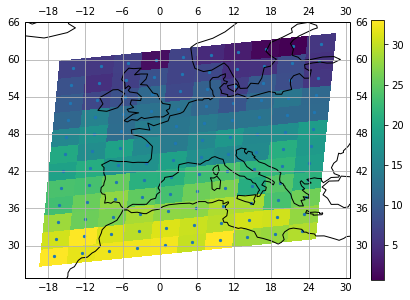

In [3]:
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
temperatures.plot.pcolormesh('lon', 'lat', ax=ax, infer_intervals=True);
ax.scatter(lon, lat, transform=ccrs.PlateCarree(), s=5)
plt.tight_layout()

Now, that looks suprisingly credible, doesn't it?

The blue dots in the plot identify the centres of each pixel, whose boundaries are automatically inferred by xarray.

What we want to achieve is to come up with a way to compare distances between a reference point, and all centre pixels, and pick the minimum value. But first, we need to dig a bit deeper on what it actually means to measure distances on the surface of our planet.

## On the distance between two points on planet Earth

How do we compute the distance between two points, given their geodetic (latitude/longitude/altitude) coordinates?
Despite a recent resurgence of the old myth, our earth is definitely not flat. That means: put that Pythagorean theorem back in the drawer.

The subject of [geographical distance](https://en.wikipedia.org/wiki/Geographical_distance) is considerably elaborated and we will not even try to cover it all in this post. It suffices to say that there are several ways to approximate the earth's surface shape, and each of these approximations comes with a way to measure distances on it.

In this post, we are going to use the cartesian or [ECEF](https://en.wikipedia.org/wiki/ECEF) ("earth-centered, earth-fixed") geographic coordinate system, which represents positions (in meters) as $X$, $Y$, and $Z$ coordinates, approximating the earth surface as an ellipsoid of revolution (close enough for our purposes). Once we convert our latitude/longitude coordinates to cartesian coordinates, measuring the distance between two points is as simple as computing the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between them.

The conversion between cartesian and geodetic coordinates latitude, longitude and ellipsoidal $(\phi, \lambda, h)$ is done according to:

$$
\left[\begin{array}{c}X \\ Y \\ Z \end{array}\right] = \left[\begin{array}{c} (r_n+h) \cos\phi \cos\lambda \\ 
(r_n + h) \cos\phi \sin\lambda \\ 
((1 - e^2) r_n + h) \sin\phi \end{array}\right]
$$

Where $r_n=\frac{a}{\sqrt{1-e^2\sin^2\phi}}$ is the local curvature of the ellipsoid along the first vertical, and where $e$, the first eccentricity, and $a$, the semi-major axis, are the parameters defining the ellipsoid.  

Assuming that our dataset provides coordinates of the centre pixel on the earth's surface ($h = 0$), we can derive the following conversion formulas:

$$
\left[\begin{array}{c}X \\ Y \\ Z \end{array}\right] = \left[\begin{array}{c} r_n\cos\phi \cos\lambda \\ 
r_n \cos\phi \sin\lambda \\ (1 - e^2) r_n \sin\phi \end{array}\right]
$$

Now that we learned a bit of [MathJax](https://www.mathjax.org) and found a way to convert our pixels' coordinates in cartesian coordinates, let's start to think about an efficient way to compute the minimum distance between all pixels and a reference point.

## Finding the closest

Our problem falls into the class of nearest neighbour searches. A common approach when it comes to finding the nearest neighbour in a number of points with $k$ dimensions is to use a KD-tree, or $k$-dimensional tree. KD-trees allow to efficiently perform searches like "all points at distance lower than $r$ from $x$" or "$k$ nearest neighbors of $x$".  

Luckily, the SciPy library provides a very efficient [KD-tree implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html) so we will be spared from having to write our own. Once we have constructed our tree, all we have to do is to populate it with a $(n, m)$ shaped array of points and then query it the nearest neighbor to a reference point. In our case $n$ will be equal to the total number of ground pixels, and $m$ will be 3, as in our three dimensions $X$, $Y$, and $Z$.

We will have to make use of some NumPy acrobatics to reshape our data structures from a two-dimensional grid to a one-dimensional array, and to convert the returned one-dimensional index to a set of two indices on our original grid. For sake of efficiency, we can wrap the geodetic coordinates conversion and the KD-tree initialization in a class. In this way, we won't have to transform coordinates and reconstruct the tree each time we want to look up a new set of points.

In [4]:
class KDTreeIndex():
    
    """ A KD-tree implementation for fast point lookup on a 2D grid
    
    Keyword arguments: 
    dataset -- a xarray DataArray containing lat/lon coordinates
               (named 'lat' and 'lon' respectively)
               
    """
    
    def transform_coordinates(self, coords):
        """ Transform coordinates from geodetic to cartesian
        
        Keyword arguments:
        coords - a set of lan/lon coordinates (e.g. a tuple or 
                 an array of tuples)
        """
        # WGS 84 reference coordinate system parameters
        A = 6378.137 # major axis [km]   
        E2 = 6.69437999014e-3 # eccentricity squared    
        
        coords = np.asarray(coords).astype(np.float)
        
        # is coords a tuple? Convert it to an one-element array of tuples
        if coords.ndim == 1:
            coords = np.array([coords])
        
        # convert to radiants
        lat_rad = np.radians(coords[:,0])
        lon_rad = np.radians(coords[:,1]) 
        
        # convert to cartesian coordinates
        r_n = A / (np.sqrt(1 - E2 * (np.sin(lat_rad) ** 2)))
        x = r_n * np.cos(lat_rad) * np.cos(lon_rad)
        y = r_n * np.cos(lat_rad) * np.sin(lon_rad)
        z = r_n * (1 - E2) * np.sin(lat_rad)
        
        return np.column_stack((x, y, z))
    
    def __init__(self, dataset):
        # store original dataset shape   
        self.shape = dataset.shape
        
        # reshape and stack coordinates
        coords = np.column_stack((dataset.lat.values.ravel(),
                                  dataset.lon.values.ravel()))
        
        # construct KD-tree
        self.tree = spatial.cKDTree(self.transform_coordinates(coords))
        
    def query(self, point):
        """ Query the kd-tree for nearest neighbour.
        
        Keyword arguments:
        point -- a (lat, lon) tuple or array of tuples
        """
        _, index = self.tree.query(self.transform_coordinates(point))
        
        # regrid to 2D grid
        index = np.unravel_index(index, self.shape)
        
        # return DataArray indexers
        return xr.DataArray(index[0], dims='pixel'), \
               xr.DataArray(index[1], dims='pixel')
    
    def query_ball_point(self, point, radius):
        """ Query the kd-tree for all points within distance 
        r of point(s) x
        
        Keyword arguments:
        point -- a (lat, lon) tuple or array of tuples
        """
        
        index = self.tree.query_ball_point(self.transform_coordinates(point),
                                              radius)

        # regrid to 2D grid 
        index = np.unravel_index(index[0], self.shape)
        
        # return DataArray indexers
        return xr.DataArray(index[0], dims='pixel'), \
               xr.DataArray(index[1], dims='pixel')

The cool part about this *quick and dirty* implementation is that it does not really matter whether we query the tree by using one or multiple points, the logic in the `transform_coordinates` method is going to take care of that.  

Let's put our tree into action:

In [5]:
ground_pixel_tree = KDTreeIndex(temperatures)

We can now query the tree the nearest ground pixel to Rome, for example:

In [6]:
rome = (41.9028, 12.4964)
rome_index = ground_pixel_tree.query(rome)
print(temperatures[rome_index])

<xarray.DataArray (pixel: 1)>
array([ 23.854322])
Coordinates:
    lat      (pixel) float64 41.98
    lon      (pixel) float64 10.76
Dimensions without coordinates: pixel


Which tells us the coordinates of the centre of the closest ground pixel to rome, and the temperature around there. Nice and warm in Rome, as expected.

The `query` method actually returns two xarray `DataArray` objects: a scanline and a ground pixel indexer. We can then use them to index our dataset making use of xarray's [pointwise indexing](http://xarray.pydata.org/en/stable/indexing.html#more-advanced-indexing).

 Since we are curious people, let's sneak a peek at the returned `index` variable:

In [7]:
print(rome_index)

(<xarray.DataArray (pixel: 1)>
array([4])
Dimensions without coordinates: pixel, <xarray.DataArray (pixel: 1)>
array([6])
Dimensions without coordinates: pixel)


There they are our scanline and ground pixel indexes, buried deep down in our indexers! But we don't have to care much about the implementation details, xarray will do most of the magic for us.

What about querying the tree for multiple locations? Let's add two more cities:

In [8]:
paris = (48.8566, 2.3522)
london = (51.5074, 0.1278)
cities_index = ground_pixel_tree.query([rome, paris, london])
print(temperatures[cities_index])

<xarray.DataArray (pixel: 3)>
array([ 23.854322,  13.448063,  12.917733])
Coordinates:
    lat      (pixel) float64 41.98 49.36 51.67
    lon      (pixel) float64 10.76 2.687 -1.485
Dimensions without coordinates: pixel


Here we have temperatures and coordinates of the closest ground pixels to our chosen cities.

We can now easily mark the selected ground pixels on our map:

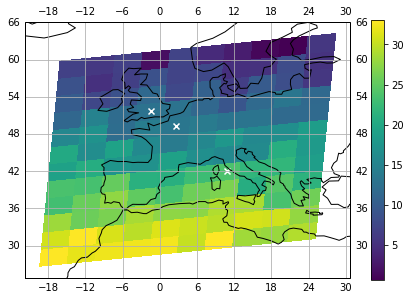

In [9]:
ax = plt.subplot(projection=ccrs.PlateCarree())
temperatures.plot.pcolormesh('lon', 'lat', ax=ax, infer_intervals=True);
ax.scatter(temperatures.lon[cities_index], 
           temperatures.lat[cities_index], 
           marker='x', color='w', transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.tight_layout()

That looks great!

As a cherry on the cake exercise, we could also very easily lookup all ground pixels within a given distance from a reference point, by using the `query_ball_point` method in SciPy's KD-tree implementation. 

Let's find out which ground pixels fall into a 700km radius from Paris:

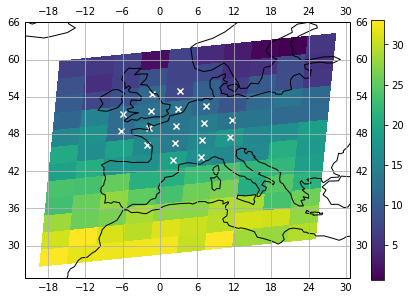

In [10]:
ball_point_index = ground_pixel_tree.query_ball_point(paris, 700)

ax = plt.subplot(projection=ccrs.PlateCarree())
temperatures.plot.pcolormesh('lon', 'lat', ax=ax, infer_intervals=True);
ax.scatter(temperatures.lon[ball_point_index], 
           temperatures.lat[ball_point_index], 
           marker='x', color='w', transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.tight_layout()

## Wrapping up

In this post we covered several topics:
* What it means to measure distances on the surface of the earth.
* How to look up the nearest neighbour in a set of points.
* How to do pointwise indexing on an xarray's `DataArray`.  

Each of this topics, especially the first two, can be discussed at much greater length. For example, we could have used considered [other ways](https://en.wikipedia.org/wiki/Geographical_distance#Tunnel_distance) to measure distances. Or, we could have tried different nearest neighbour search algorithms (this [article](https://www.unidata.ucar.edu/blogs/developer/en/entry/accessing_netcdf_data_by_coordinates) provides a very comprehensive comparison between several approaches).

But our KD-tree built on transformed coordinates solution should fully (and quickly) satisfy the need to select ground pixels on a two-dimensional grid, based on their distance to a reference point.

Incidentally, I found out that an xarray's wrapper for KD-tree [is on the pipeline](https://github.com/pydata/xarray/issues/475#issuecomment-125468579), but until then, we will happily make use of our little home-brewed solution!

I hope you enjoyed this post, feel free to comment if you have questions or remarks.

*This post was written entirely in the Jupyter notebook. You can download this notebook on my [GitHub repository](https://github.com/stefanomattia/jupyter-notebooks/tree/master/earth-observation).*